# Import Data

In [122]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from numpy import loadtxt
directory="/Users/lambda/Documents/Code/CaliforniaDrought2016/Data/"
file=directory+"Pressure/slp.mon.mean.nc"
nc=Dataset(file,'r')

lat=nc.variables["lat"][10:29]##20-65##
lon=nc.variables["lon"][80:105]##200-260##
pressure=nc.variables["slp"][0:816,10:29,80:105]

directory='/Users/lambda/Documents/Code/CaliforniaDrought2017/'
SCAMonthTotal= loadtxt(directory+'WSCAPrecipitation.txt')
NCAMonthTotal= loadtxt(directory+'WNCAPrecipitation.txt')
ORMonthTotal= loadtxt(directory+'WORPrecipitation.txt')
WAMonthTotal= loadtxt(directory+'WWAPrecipitation.txt')
winter=loadtxt(directory+'winter.txt')
winter=winter.tolist()
winter=map(int, winter)
winter=map(lambda x: x-1,winter)
pressure=pressure[winter]
SCAMonthTotal=SCAMonthTotal.reshape((408, 1))
NCAMonthTotal=SCAMonthTotal.reshape((408, 1))
ORMonthTotal=ORMonthTotal.reshape((408, 1))
WAMonthTotal=WAMonthTotal.reshape((408, 1))
rlat=19
rlon=25

In [123]:
y_data=SCAMonthTotal
y_data=(y_data-np.mean(y_data))/np.std(y_data)

In [124]:
x_data=pressure.flatten()
l=len(pressure)
x_data=np.reshape((x_data-np.mean(x_data))/np.std(x_data),(l,rlat,rlon,1))

# Set Computing Graph

### HyperParameters

In [125]:
ptraining=272
ctraining=[]
ctest=[]
#Convolution Layer Parameters
wc1=5
nc1=3
wc2=5 
nc2=1
wp1=2
wp2=2
fl=(rlat-wc1-wc2-wp1-wp2+4)*(rlon-wc1-wc2-wp1-wp2+4)*nc2
wfc=50
wfc2=10

### Graph

In [126]:
import tensorflow as tf
tf.reset_default_graph()
x = tf.placeholder('float', [None, rlat,rlon,1])
y = tf.placeholder('float',[None,1])
def convolutional_neural_network(x):
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='VALID')
    def maxpool2d(x,W):
        return tf.nn.max_pool(x, [1,W,W,1], strides=[1,1,1,1], padding='VALID')
    weights = {'W_conv1':tf.Variable(tf.random_normal([wc1,wc1,1,nc1],stddev=0.0001,name="W_conv1")),
               'W_conv2':tf.Variable(tf.random_normal([wc2,wc2,nc1,nc2],stddev=0.0001)),
               'W_fc':tf.Variable(tf.random_normal([fl,wfc],stddev=0.0001)),
               'W_fc2':tf.Variable(tf.random_normal([wfc,wfc2],stddev=0.0001)),
               'out':tf.Variable(tf.random_normal([wfc2, 1],stddev=0.0001))}

    biases = { 'b_conv1':tf.Variable(tf.random_normal([nc1],stddev=0.001)),
               'b_conv2':tf.Variable(tf.random_normal([nc2],stddev=0.001)),
               'b_fc':tf.Variable(tf.random_normal([wfc],stddev=0.001)),
               'b_fc2':tf.Variable(tf.random_normal([wfc2],stddev=0.001)),
               'out':tf.Variable(tf.random_normal([1],stddev=0.001))}
     
    
    conv1 = conv2d(x, weights['W_conv1']) + biases['b_conv1']
    pool1 = maxpool2d(conv1,wp1)

    conv2 = conv2d(pool1, weights['W_conv2']) + biases['b_conv2']
    pool2 = maxpool2d(conv2,wp2)

    fc = tf.reshape(pool2,[-1, fl])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc2 = tf.nn.relu(tf.matmul(fc, weights['W_fc2'])+biases['b_fc2'])
    output = tf.matmul(fc2, weights['out'])+biases['out'] 
    return output

In [127]:
prediction = convolutional_neural_network(x)
cost = tf.reduce_mean(tf.square(prediction-y))
optimizer = tf.train.AdamOptimizer(0.0001).minimize(cost)
all_saver = tf.train.Saver()

# Train

In [147]:
def train_neural_network(x):
    gtestcost=np.inf
    batch=136
    epoches=3000
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epoches):
            for b in range(ptraining/batch):
                epoch_x=x_data[b*batch:(b+1)*batch,:,:,:]
                epoch_y=y_data[b*batch:(b+1)*batch,:]
                sess.run(optimizer, feed_dict={x: epoch_x, y: epoch_y})
                trainingcost=sess.run(cost, feed_dict={x: epoch_x, y: epoch_y})
                ctraining.append(trainingcost)
            testcost=sess.run(cost, feed_dict={x: x_data[ptraining:,:,:,:], 
                                                   y: y_data[ptraining:,:]})
            if testcost<0.3:
                print testcost
            if testcost < gtestcost and (testcost<0.28):
                gtestcost=testcost
                all_saver.save(sess, 'CNN_Trained')
            ctest.append(testcost)
        result=sess.run(prediction,feed_dict={x: x_data})
        sess.close()
    return result

In [ ]:
tf.set_random_seed(2)
train_neural_network(x)

In [139]:
[np.min(ctest),np.min(ctraining)]

[0.27178124, 0.10401281]

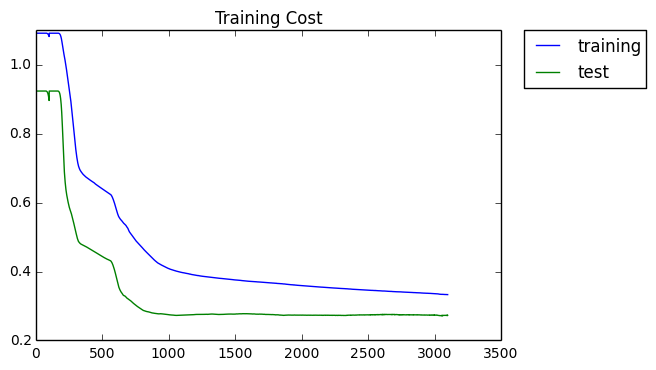

In [145]:
import matplotlib.pyplot as plt
plt.plot(ctraining[0:len(ctraining):2], label="training")
plt.plot(ctest,label="test")
plt.title("Training Cost")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Result

In [142]:
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    # Restore model weights from previously saved model
    load_path =all_saver.restore(sess, '/Users/lambda/Documents/Code/Lib/TensorFlow/CNN_Trained')
    trainingresult=sess.run(prediction,feed_dict={x:x_data[0:ptraining,:,:,:]})
    testresult=sess.run(prediction,feed_dict={x:x_data[ptraining:,:,:,:]})

InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [135,50] rhs shape= [2052,50]
	 [[Node: save/Assign_6 = Assign[T=DT_FLOAT, _class=["loc:@Variable_2"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_2, save/RestoreV2_6)]]

Caused by op u'save/Assign_6', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Library/Python/2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Library/Python/2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Python/2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Library/Python/2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Python/2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Python/2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-127-6ba16f24c8b9>", line 4, in <module>
    all_saver = tf.train.Saver()
  File "/Library/Python/2.7/site-packages/tensorflow/python/training/saver.py", line 1051, in __init__
    self.build()
  File "/Library/Python/2.7/site-packages/tensorflow/python/training/saver.py", line 1081, in build
    restore_sequentially=self._restore_sequentially)
  File "/Library/Python/2.7/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/Library/Python/2.7/site-packages/tensorflow/python/training/saver.py", line 414, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "/Library/Python/2.7/site-packages/tensorflow/python/training/saver.py", line 155, in restore
    self.op.get_shape().is_fully_defined())
  File "/Library/Python/2.7/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [135,50] rhs shape= [2052,50]
	 [[Node: save/Assign_6 = Assign[T=DT_FLOAT, _class=["loc:@Variable_2"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Variable_2, save/RestoreV2_6)]]


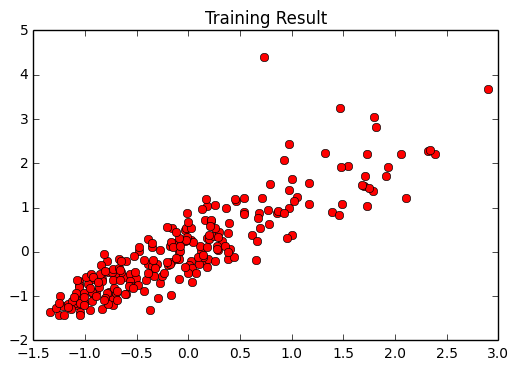

In [104]:
import matplotlib.pyplot as plt
plt.plot(trainingresult,y_data[0:ptraining,:],'ro')
plt.title("Training Result")
plt.show()

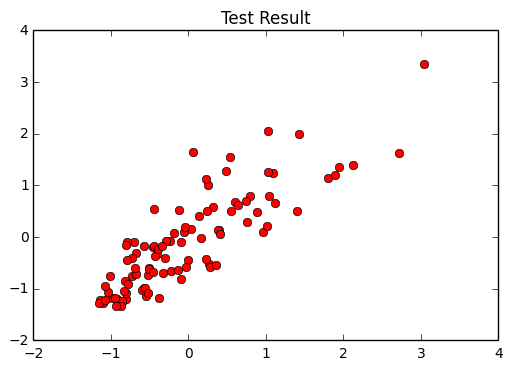

In [105]:
import matplotlib.pyplot as plt
plt.plot(testresult,y_data[ptraining:,:],'ro')
plt.title("Test Result")
plt.show()

In [106]:
np.corrcoef(map(lambda x:x[0],trainingresult[0:ptraining].tolist()),
            map(lambda x:x[0],y_data[0:ptraining,:][0:ptraining].tolist()))[0][1]

0.8862166750511461

In [107]:
np.corrcoef(map(lambda x:x[0],testresult[0:240].tolist()),
         map(lambda x:x[0],y_data[ptraining:,:].tolist()))[0][1]

0.85357051147777685

In [108]:
map(lambda m:np.corrcoef(map(lambda x:x[0],trainingresult[m:ptraining:12].tolist()),
                         map(lambda x:x[0],y_data[0:ptraining,:][m:ptraining:12].tolist()))[0][1],
    range(12))

[0.91738260880152744,
 0.86292725528473102,
 0.80608595383684722,
 0.93386113692397943,
 0.88760842273133223,
 0.92466962297190702,
 0.86191934356091948,
 0.84742639719268997,
 0.9271526870621527,
 0.89698780769030617,
 0.92215490824770574,
 0.95161881780544233]

In [109]:
map(lambda m:np.corrcoef(map(lambda x:x[0],testresult[m:240:12].tolist()),
                         map(lambda x:x[0],y_data[ptraining:,:][m:ptraining:12].tolist()))[0][1],
    range(12))

[0.73481582327270323,
 0.70673855267344132,
 0.91772788805392302,
 0.77000822601789043,
 0.86732928840950307,
 0.85778087611426757,
 0.83743175785467283,
 0.79381507337753565,
 0.60444102496315888,
 0.90104750393494748,
 0.87944141976718893,
 0.97629486036801283]